# ATLAS Classification Experiments

In this notebook, I want to answer some questions. The main tool for investigation will be a set of uncertainty measures generated with $k$-fold committee classification. Each ATLAS object will be assigned an uncertainty.

- What is the distribution of these uncertainties?
- Are the very certain objects interesting?
- Are the very uncertain objects interesting?
- If we compute a similar uncertainty for each IR object, is there a relationship between the uncertainty of the IR objects and the radio subjects they appear near?
- Do RGZ and Norris agree more often on the certain objects than the uncertain objects?

## Setup: A classifier for the Radio Galaxy Zoo

In this section, I'll build a classifier class to make the problem a little easier to grasp. A `RGZClassifier` will have access to all IR objects in the crowdastro database. It will have a `train` method which takes an IR label training set and a set of IR indices as arguments and trains the classifier, and a `predict` method which takes an ATLAS subject vector and returns an IR index.

In [17]:
import collections

from astropy.coordinates import SkyCoord
import h5py
import numpy
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.pipeline
import sklearn.preprocessing

ARCMIN = 1 / 60
CROWDASTRO_H5_PATH = '../data/crowdastro.h5'
IMAGE_SIZE = 200 * 200
NORRIS_DAT_PATH = '../data/norris_2006_atlas_classifications_ra_dec_only.dat'
TRAINING_H5_PATH = '../data/training.h5'

with h5py.File(CROWDASTRO_H5_PATH, 'r') as f_h5:
    N_ASTRO = 5 if f_h5.attrs['ir_survey'] == 'wise' else 6

In [4]:
class RGZClassifier(object):
    
    def __init__(self, ir_features, n_astro, Classifier=sklearn.linear_model.LogisticRegression):
        self.ir_features = ir_features
        self.n_astro = n_astro
        self._classifier = Classifier(class_weight='balanced')
        self._astro_transformer = sklearn.pipeline.Pipeline([
            ('normalise', sklearn.preprocessing.Normalizer()),
            ('scale', sklearn.preprocessing.StandardScaler()),
        ])
        self._image_transformer = sklearn.pipeline.Pipeline([
            ('normalise', sklearn.preprocessing.Normalizer()),
        ])
    
    def _fit_transformers(self, ir_indices):
        self._astro_transformer.fit(self.ir_features[ir_indices, :self.n_astro])
        self._image_transformer.fit(self.ir_features[ir_indices, self.n_astro:])
    
    def _transform(self, features):
        return numpy.hstack([
            self._astro_transformer.transform(features[:, :self.n_astro]),
            self._image_transformer.transform(features[:, self.n_astro:]),
        ])
    
    def train(self, ir_indices, ir_labels):
        self._fit_transformers(ir_indices)
        ir_features = self._transform(self.ir_features[ir_indices])
        self._classifier.fit(ir_features, ir_labels)
    
    def _predict(self, atlas_vector):
        # Split the ATLAS vector into its components.
        position = atlas_vector[:2]
        image = atlas_vector[2:2 + IMAGE_SIZE]
        distances = atlas_vector[2 + IMAGE_SIZE:]
        # Get nearby IR objects and their features.
        nearby_indices = (distances < ARCMIN).nonzero()[0]
        ir_features = self._transform(self.ir_features[nearby_indices])
        # Find how likely each object is to be the host galaxy.
        probabilities = self._classifier.predict_proba(ir_features)[:, 1]
        return nearby_indices, probabilities
    
    def predict(self, atlas_vector):
        nearby_indices, probabilities = self._predict(atlas_vector)
        # Return the index of the most likely host galaxy.
        return nearby_indices[probabilities.argmax()]
    
    def predict_probabilities(self, atlas_vector):
        nearby_indices, probabilities = self._predict(atlas_vector)
        out_probabilities = numpy.zeros(self.ir_features.shape[0])
        out_probabilities[nearby_indices] = probabilities
        return out_probabilities

In [5]:
# Some helper functions for testing.
def get_groundtruth_labels(atlas_vector, ir_labels):
    distances = atlas_vector[2 + IMAGE_SIZE:]
    nearby_indices = (distances < ARCMIN).nonzero()[0]
    nearby_labels = ir_labels[nearby_indices]
    groundtruth = nearby_labels.nonzero()[0]
    return nearby_indices[groundtruth]

In [6]:
# Let's test it out.
with h5py.File(TRAINING_H5_PATH, 'r') as training_h5, \
     h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    ir_features = training_h5['features'].value
    ir_labels = training_h5['labels'].value
    ir_train_indices = training_h5['is_ir_train'].value.nonzero()[0]

    classifier = RGZClassifier(ir_features, N_ASTRO)
    classifier.train(ir_train_indices, ir_labels[ir_train_indices])

    atlas_vectors = crowdastro_h5['/atlas/cdfs/numeric']
    atlas_test_indices = training_h5['is_atlas_test'].value.nonzero()[0]
    
    n_correct = 0
    n_total = 0
    for atlas_index in atlas_test_indices:
        atlas_vector = atlas_vectors[atlas_index]
        groundtruths = get_groundtruth_labels(atlas_vector, ir_labels)
        prediction = classifier.predict(atlas_vector)
        n_correct += prediction in groundtruths
        n_total += 1
    
    print('{:.02%}'.format(n_correct/n_total))

63.94%


## Uncertainty by committee

In this section, I'll make a committee of 10 classifiers which will learn on different subsets of the training data. I'll use 5-fold cross-validation to generate 10 classifications for each ATLAS object, and the percentage of agreement with the majority will form an uncertainty estimate for each object.

In [7]:
def generate_subset(p, indices):
    indices = indices.copy()
    numpy.random.shuffle(indices)
    return indices[:p * len(indices)]

In [8]:
def generate_atlas_committee_classifications(n_committee=10, n_folds=5, subset_size=0.6):
    with h5py.File(TRAINING_H5_PATH, 'r') as training_h5, \
         h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:

        # Generate the n_folds folds.
        atlas_vectors = crowdastro_h5['/atlas/cdfs/numeric']
        folds = sklearn.cross_validation.KFold(atlas_vectors.shape[0],
                                               n_folds=n_folds,
                                               shuffle=True,
                                               random_state=0)

        # Generate n_committee classifiers.
        ir_features = training_h5['features'].value
        ir_labels = training_h5['labels'].value
        classifiers = [RGZClassifier(ir_features, N_ASTRO) for _ in range(n_committee)]
        
        # Somewhere to store the classifications.
        classifications = numpy.zeros((atlas_vectors.shape[0], n_committee))
        
        # Generate the classifications.
        for train_indices, test_indices in folds:
            # Precompute which IR objects should be reserved for testing.
            # See later comment.
            test_ir_indices = set()
            for atlas_index in test_indices:
                distances = atlas_vectors[atlas_index, 2 + IMAGE_SIZE:]
                nearby_indices = (distances < ARCMIN).nonzero()[0]
                for ir_index in nearby_indices:
                    test_ir_indices.add(ir_index)

            for index, classifier in enumerate(classifiers):
                train_subset = generate_subset(subset_size, train_indices)
                # This subset is of ATLAS indicies, so we need to convert this
                # into IR indices. An IR object is in the training set if it is
                # nearby a training ATLAS object and *not* nearby a testing ATLAS
                # object. The easiest way to do this is to find all nearby indices,
                # and all testing indices, and then find the set difference.
                train_ir_indices = set()
                for atlas_index in train_subset:
                    distances = atlas_vectors[atlas_index, 2 + IMAGE_SIZE:]
                    nearby_indices = (distances < ARCMIN).nonzero()[0]
                    for ir_index in nearby_indices:
                        train_ir_indices.add(ir_index)
                
                train_ir_indices -= test_ir_indices
                train_ir_indices = numpy.array(sorted(train_ir_indices))

                classifier.train(train_ir_indices, ir_labels[train_ir_indices])
                
                # Classify all the test subjects.
                for atlas_index in test_indices:
                    classification = classifier.predict(atlas_vectors[atlas_index])
                    classifications[atlas_index, index] = classification
        
        return classifications

In [9]:
def generate_atlas_uncertainties(n_committee=10, n_folds=5, subset_size=0.6):
    classifications = generate_atlas_committee_classifications(
            n_committee=n_committee, n_folds=n_folds, subset_size=subset_size)
    uncertainties = []
    for atlas_object_classifications in classifications:
        majority = numpy.bincount(atlas_object_classifications.astype('int')).argmax()
        eq = atlas_object_classifications == majority
        agreement = eq.sum() / eq.shape[0]
        uncertainties.append(1 - agreement)
    
    return numpy.array(uncertainties)

In [10]:
atlas_uncertainties = generate_atlas_uncertainties()

K:\Languages\Python35_64\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


## ATLAS uncertainty distribution

In this section, I will look at the uncertainties generated by the committee.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

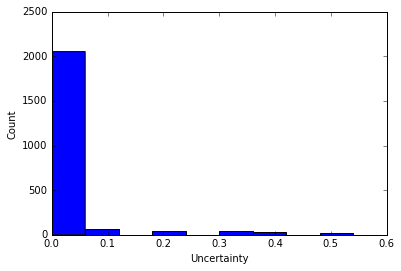

In [12]:
plt.hist(atlas_uncertainties)
plt.xlabel('Uncertainty')
plt.ylabel('Count')
plt.show()

It seems like most objects have high certainty. Maybe we need more variance in our classifiers to spread this out a little? How many objects have nonzero uncertainty?

In [13]:
print('{:.02%}'.format(len(atlas_uncertainties.nonzero()[0]) / len(atlas_uncertainties)))

9.32%


Let's try adding 50% random forests.

In [19]:
def generate_atlas_committee_classifications_half_rf(n_committee=10, n_folds=5, subset_size=0.6):
    with h5py.File(TRAINING_H5_PATH, 'r') as training_h5, \
         h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:

        # Generate the n_folds folds.
        atlas_vectors = crowdastro_h5['/atlas/cdfs/numeric']
        folds = sklearn.cross_validation.KFold(atlas_vectors.shape[0],
                                               n_folds=n_folds,
                                               shuffle=True,
                                               random_state=0)

        # Generate n_committee classifiers.
        ir_features = training_h5['features'].value
        ir_labels = training_h5['labels'].value
        classifiers = (
                [RGZClassifier(ir_features, N_ASTRO) for _ in range(n_committee // 2)]
                + [RGZClassifier(ir_features, N_ASTRO, sklearn.ensemble.RandomForestClassifier)
                   for _ in range(n_committee // 2)])
        
        # Somewhere to store the classifications.
        classifications = numpy.zeros((atlas_vectors.shape[0], n_committee))
        
        # Generate the classifications.
        for train_indices, test_indices in folds:
            # Precompute which IR objects should be reserved for testing.
            # See later comment.
            test_ir_indices = set()
            for atlas_index in test_indices:
                distances = atlas_vectors[atlas_index, 2 + IMAGE_SIZE:]
                nearby_indices = (distances < ARCMIN).nonzero()[0]
                for ir_index in nearby_indices:
                    test_ir_indices.add(ir_index)

            for index, classifier in enumerate(classifiers):
                train_subset = generate_subset(subset_size, train_indices)
                # This subset is of ATLAS indicies, so we need to convert this
                # into IR indices. An IR object is in the training set if it is
                # nearby a training ATLAS object and *not* nearby a testing ATLAS
                # object. The easiest way to do this is to find all nearby indices,
                # and all testing indices, and then find the set difference.
                train_ir_indices = set()
                for atlas_index in train_subset:
                    distances = atlas_vectors[atlas_index, 2 + IMAGE_SIZE:]
                    nearby_indices = (distances < ARCMIN).nonzero()[0]
                    for ir_index in nearby_indices:
                        train_ir_indices.add(ir_index)
                
                train_ir_indices -= test_ir_indices
                train_ir_indices = numpy.array(sorted(train_ir_indices))

                classifier.train(train_ir_indices, ir_labels[train_ir_indices])
                
                # Classify all the test subjects.
                for atlas_index in test_indices:
                    classification = classifier.predict(atlas_vectors[atlas_index])
                    classifications[atlas_index, index] = classification
        
        return classifications

def generate_atlas_uncertainties_half_rf(n_committee=10, n_folds=5, subset_size=0.6):
    classifications = generate_atlas_committee_classifications_half_rf(
            n_committee=n_committee, n_folds=n_folds, subset_size=subset_size)
    uncertainties = []
    for atlas_object_classifications in classifications:
        majority = numpy.bincount(atlas_object_classifications.astype('int')).argmax()
        eq = atlas_object_classifications == majority
        agreement = eq.sum() / eq.shape[0]
        uncertainties.append(1 - agreement)
    
    return numpy.array(uncertainties)
    
atlas_uncertainties = generate_atlas_uncertainties_half_rf(n_committee=10)

K:\Languages\Python35_64\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
K:\Languages\Python35_64\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
K:\Languages\Python35_64\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
K:\Languages\Python35_64\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
K:\Languages\Python35_64\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
K:\Languages\Python35_64\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarn

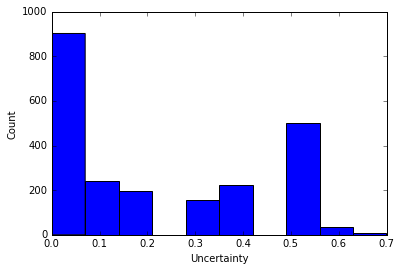

In [20]:
plt.hist(atlas_uncertainties)
plt.xlabel('Uncertainty')
plt.ylabel('Count')
plt.show()

That's a bit better.

## Are certain or uncertain subjects interesting?

Let's look at some of the "certain" classifications.

902 100% certain classifications.


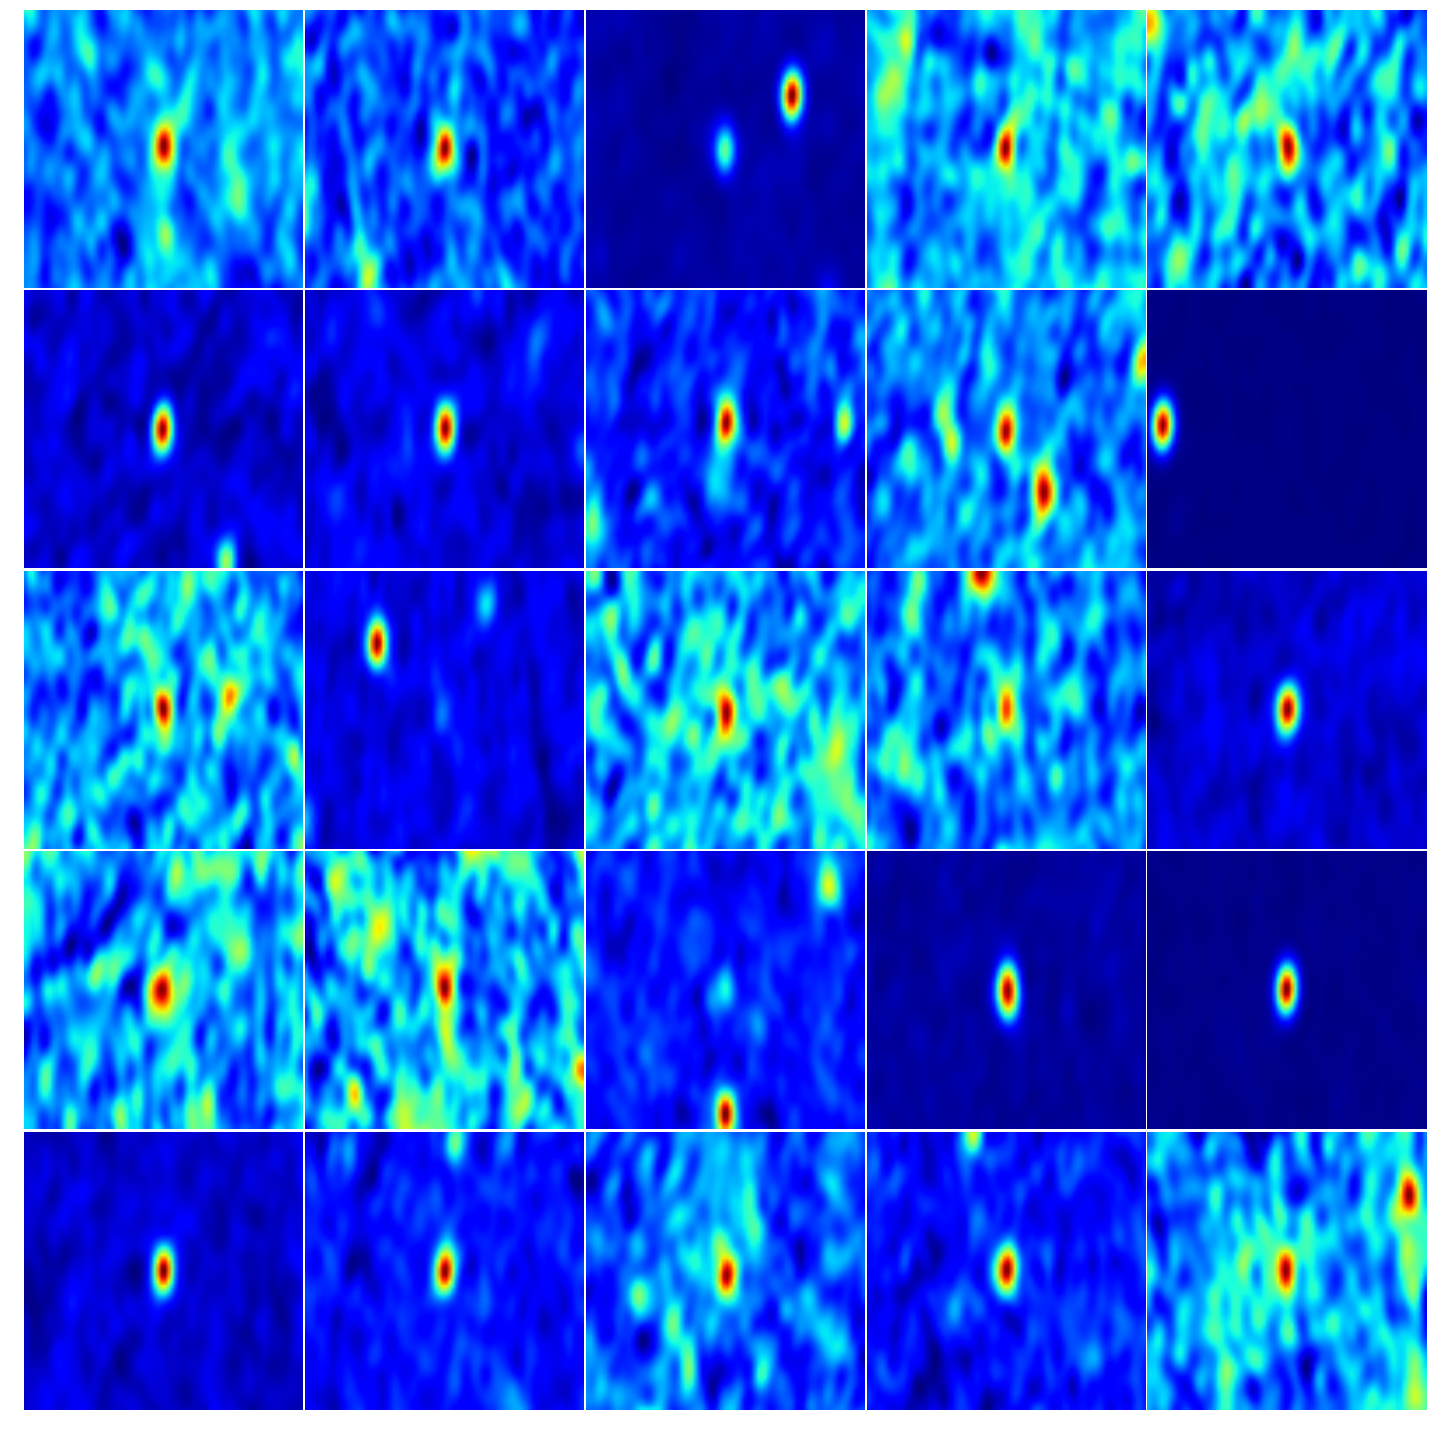

In [21]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    atlas_vectors = crowdastro_h5['/atlas/cdfs/numeric']
    
    certain = (atlas_uncertainties == 0.0).nonzero()[0]
    print('{} 100% certain classifications.'.format(len(certain)))

    numpy.random.shuffle(certain)

    figure = plt.figure(figsize=(20, 20))
    for i in range(25):
        axis = figure.add_subplot(5, 5, i + 1)
        atlas_image = atlas_vectors[certain[i], 2 : 2 + IMAGE_SIZE]
        axis.axis('off')
        plt.imshow(atlas_image.reshape((200, 200))[60 : 140, 60 : 140])
    figure.tight_layout()
    figure.subplots_adjust(wspace=0.01, hspace=0.001)

Curiously, not all compact. What about the $\geq$50% ones?

545 >=50% uncertain classifications.


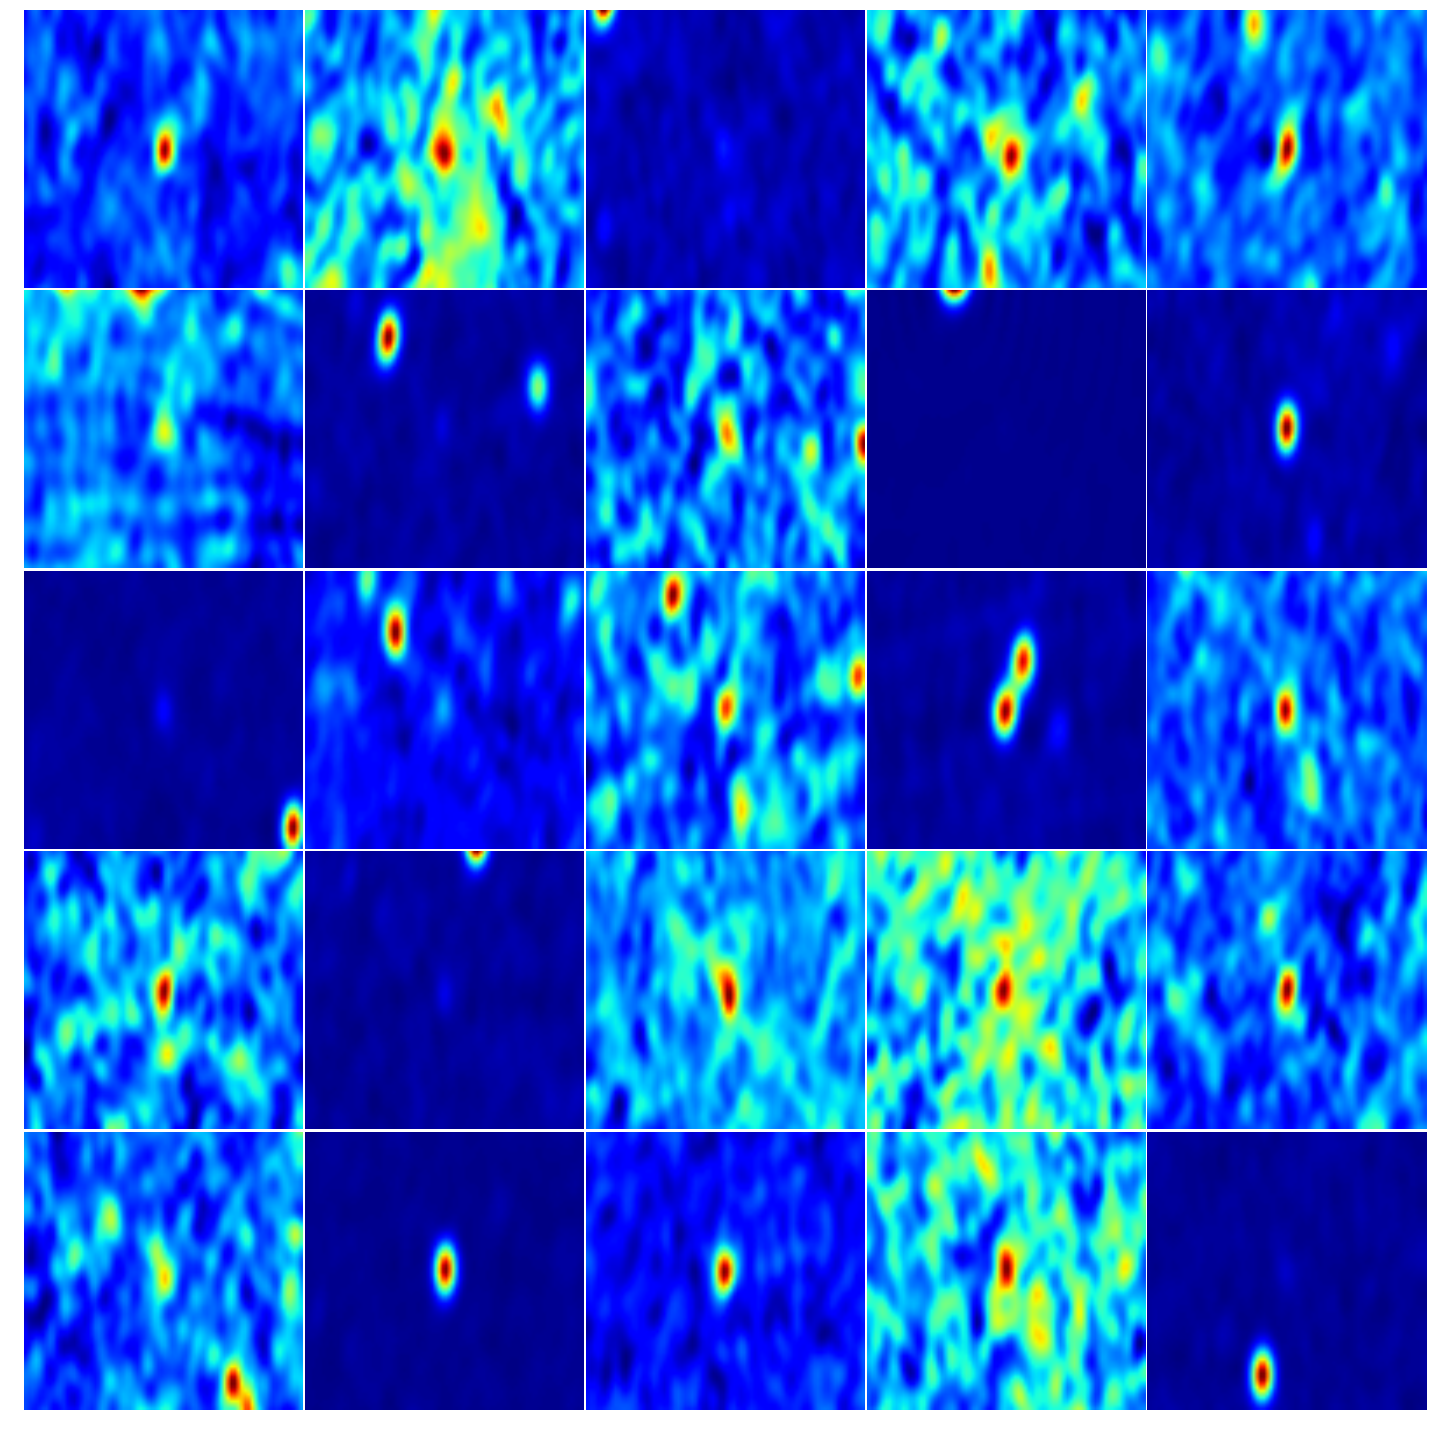

In [22]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    atlas_vectors = crowdastro_h5['/atlas/cdfs/numeric']
    
    very_uncertain = (atlas_uncertainties >= 0.5).nonzero()[0]
    print('{} >=50% uncertain classifications.'.format(len(very_uncertain)))

    numpy.random.shuffle(very_uncertain)

    figure = plt.figure(figsize=(20, 20))
    for i in range(25):
        axis = figure.add_subplot(5, 5, i + 1)
        atlas_image = atlas_vectors[very_uncertain[i], 2 : 2 + IMAGE_SIZE]
        axis.axis('off')
        plt.imshow(atlas_image.reshape((200, 200))[60 : 140, 60 : 140])
    figure.tight_layout()
    figure.subplots_adjust(wspace=0.01, hspace=0.001)

Kinda messy, but some are still compact.

## IR uncertainty distribution

In this section, I will repeat the above experiment with individual IR objects. I want to see what the distribution of disagreement looks like. Again, I'll use a committee &mdash; the standard deviation of probabilities generated by the committee for a single IR object will represent the uncertainty of that object.

In [16]:
def generate_ir_committee_classifications(n_committee=10, n_folds=5, subset_size=0.6):
    with h5py.File(TRAINING_H5_PATH, 'r') as training_h5:

        # Generate the n_folds folds.
        ir_features = training_h5['features'].value
        folds = sklearn.cross_validation.KFold(ir_features.shape[0],
                                               n_folds=n_folds,
                                               shuffle=True,
                                               random_state=0)

        # Generate n_committee classifiers.
        ir_labels = training_h5['labels'].value
        classifiers = [RGZClassifier(ir_features, N_ASTRO)._classifier for _ in range(n_committee)]
        
        # Somewhere to store the classifications.
        classifications = numpy.zeros((ir_features.shape[0], n_committee))
        
        # Generate the classifications.
        for train_indices, test_indices in folds:
            features = ir_features[train_indices]
            labels = ir_labels[train_indices]
            for index, classifier in enumerate(classifiers):
                classifier.fit(features, labels)
                probabilities = classifier.predict_proba(ir_features[test_indices])[:, 1]
                classifications[test_indices, index] = probabilities
        
        return classifications

In [17]:
def generate_ir_uncertainties(n_committee=10, n_folds=5, subset_size=0.6):
    classifications = generate_ir_committee_classifications(
            n_committee=n_committee, n_folds=n_folds, subset_size=subset_size)
    
    return classifications.std(axis=1)

In [18]:
ir_uncertainties = generate_ir_uncertainties(subset_size=0.2, n_committee=20)

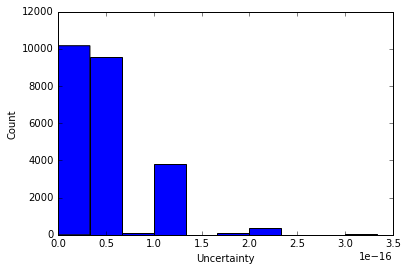

In [19]:
plt.hist(ir_uncertainties)
plt.xlabel('Uncertainty')
plt.ylabel('Count')
plt.show()

## Are the certainties of the ATLAS classifications correlated with the certainty of the IR classifications?

In [20]:
import scipy.stats

with h5py.File(TRAINING_H5_PATH, 'r') as training_h5, \
     h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    xs = []
    ys = []
    
    distances = crowdastro_h5['/atlas/cdfs/numeric'][:, 2 + IMAGE_SIZE:]
    for atlas_index in range(distances.shape[0]):
        ir_indices = (distances[atlas_index] < ARCMIN).nonzero()[0]
        atlas_uncertainty = atlas_uncertainties[atlas_index]
        ir_uncertainty = ir_uncertainties[ir_indices]
        
        xs.extend([atlas_uncertainty] * len(ir_uncertainty))
        ys.extend(ir_uncertainty)
    
    xs = numpy.array(xs)
    ys = numpy.array(ys)
    
    print(scipy.stats.pearsonr(xs, ys))

(-0.0028056914198985191, 0.61614480840229635)


Answer: no.

## Do RGZ and Norris agree more on the uncertain classifications than the certain ones for the IR task?

Let's load the labels and get a baseline:

In [32]:
with h5py.File(TRAINING_H5_PATH, 'r') as training_h5:
    crowdsourced_labels = training_h5['labels'].value

with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    ir_names = crowdastro_h5['/wise/cdfs/string'].value
    ir_positions = crowdastro_h5['/wise/cdfs/numeric'].value[:, :2]
ir_tree = sklearn.neighbors.KDTree(ir_positions)

with open(NORRIS_DAT_PATH, 'r') as norris_dat:
    norris_coords = [r.strip().split('|') for r in norris_dat]

norris_labels = numpy.zeros((len(ir_positions)))
for ra, dec in norris_coords:
    # Find a neighbour.
    skycoord = SkyCoord(ra=ra, dec=dec, unit=('hourangle', 'deg'))
    ra = skycoord.ra.degree
    dec = skycoord.dec.degree
    ((dist,),), ((ir,),) = ir_tree.query([(ra, dec)])
    if dist < 0.1:
        norris_labels[ir] = 1

print('{:.02%} Norris/RGZ disagreement.'.format((norris_labels != crowdsourced_labels).mean()))
cm = sklearn.metrics.confusion_matrix(norris_labels, crowdsourced_labels)
print(cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis])

8.16% Norris/RGZ disagreement.
[[ 0.92485598  0.07514402]
 [ 0.29503546  0.70496454]]


Now, let's filter on classifier committee agreement. If there is no disagreement, what do the labels say?

In [36]:
ir_certain_indices = ir_uncertainties == 0.0
print('{:.02%} Norris/RGZ disagreement on certain objects.'.format(
        (norris_labels != crowdsourced_labels)[ir_certain_indices].mean()))
cm = sklearn.metrics.confusion_matrix(norris_labels[ir_certain_indices], crowdsourced_labels[ir_certain_indices])
print(cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis])

7.84% Norris/RGZ disagreement on certain objects.
[[ 0.92824166  0.07175834]
 [ 0.30630631  0.69369369]]


In [38]:
ir_uncertain_indices = ir_uncertainties != 0.0
print('{:.02%} Norris/RGZ disagreement on uncertain objects.'.format(
        (norris_labels != crowdsourced_labels)[ir_uncertain_indices].mean()))
cm = sklearn.metrics.confusion_matrix(norris_labels[ir_uncertain_indices], crowdsourced_labels[ir_uncertain_indices])
print(cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis])

8.31% Norris/RGZ disagreement on uncertain objects.
[[ 0.92323704  0.07676296]
 [ 0.28985507  0.71014493]]


## The RGZ/Norris/classifier Venn diagram

How many and what are examples of subjects where

- Norris, RGZ, and the classifier all agree?
- Just Norris and RGZ agree?
- Just RGZ and the classifier agree?
- Just the classifier and Norris agree?
- All disagree?

(I'll just look at the test data to minimise CNN peeking.)

In [45]:
classifier_not_norris_rgz = []
classifier_norris_not_rgz = []
classifier_rgz_not_norris = []
classifier_rgz_norris = []

with h5py.File(TRAINING_H5_PATH, 'r') as training_h5, \
     h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    ir_features = training_h5['features'].value
    classifier = RGZClassifier(ir_features, 5)
    ir_train_indices = training_h5['is_ir_train'].value
    ir_labels = training_h5['labels'].value
    classifier.train(ir_train_indices, ir_labels[ir_train_indices])
    
    atlas_test_indices = training_h5['is_atlas_test'].value
    for atlas_index, atlas_vector in enumerate(crowdastro_h5['/atlas/cdfs/numeric'][atlas_test_indices, :]):
        prediction = classifier.predict(atlas_vector)
        if crowdsourced_labels[prediction] and norris_labels[prediction]:
            classifier_rgz_norris.append(atlas_index)
        elif crowdsourced_labels[prediction]:
            classifier_rgz_not_norris.append(atlas_index)
        elif norris_labels[prediction]:
            classifier_norris_not_rgz.append(atlas_index)
        else:
            classifier_not_norris_rgz.append(atlas_index)

([<matplotlib.patches.Wedge at 0x2978f4d73c8>,
  <matplotlib.text.Text at 0x2978f4ef128>])

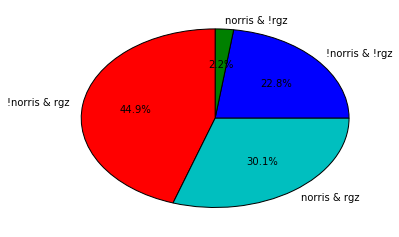

In [49]:
plt.pie([
        len(classifier_not_norris_rgz),
        len(classifier_norris_not_rgz),
        len(classifier_rgz_not_norris),
        len(classifier_rgz_norris),
    ], labels=[
        '!norris & !rgz',
        'norris & !rgz',
        '!norris & rgz',
        'norris & rgz',
    ], autopct='%1.1f%%')

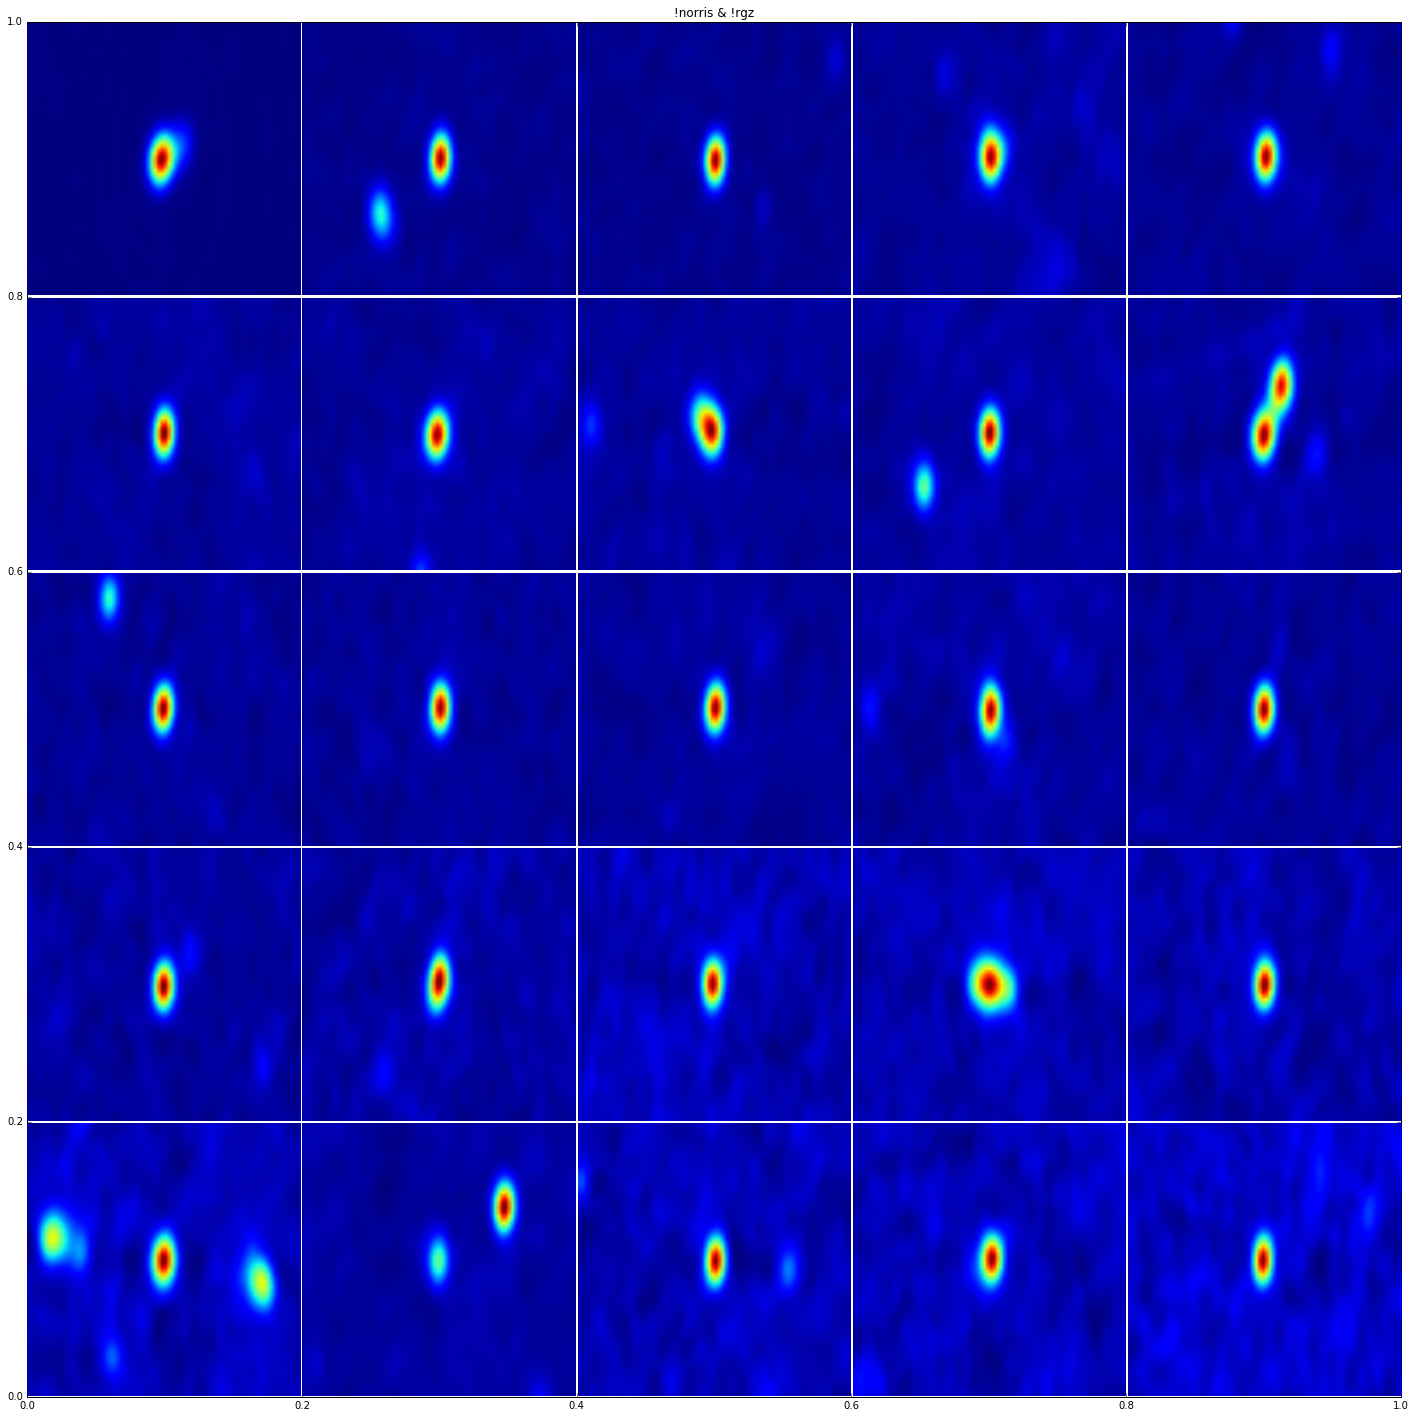

In [52]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    atlas_vectors = crowdastro_h5['/atlas/cdfs/numeric']

    figure = plt.figure(figsize=(20, 20))
    figure.gca().set_title('!norris & !rgz')
    for i in range(25):
        axis = figure.add_subplot(5, 5, i + 1)
        atlas_image = atlas_vectors[classifier_not_norris_rgz[i], 2 : 2 + IMAGE_SIZE]
        axis.axis('off')
        plt.imshow(atlas_image.reshape((200, 200))[60 : 140, 60 : 140])
    figure.tight_layout()
    figure.subplots_adjust(wspace=0.01, hspace=0.001)

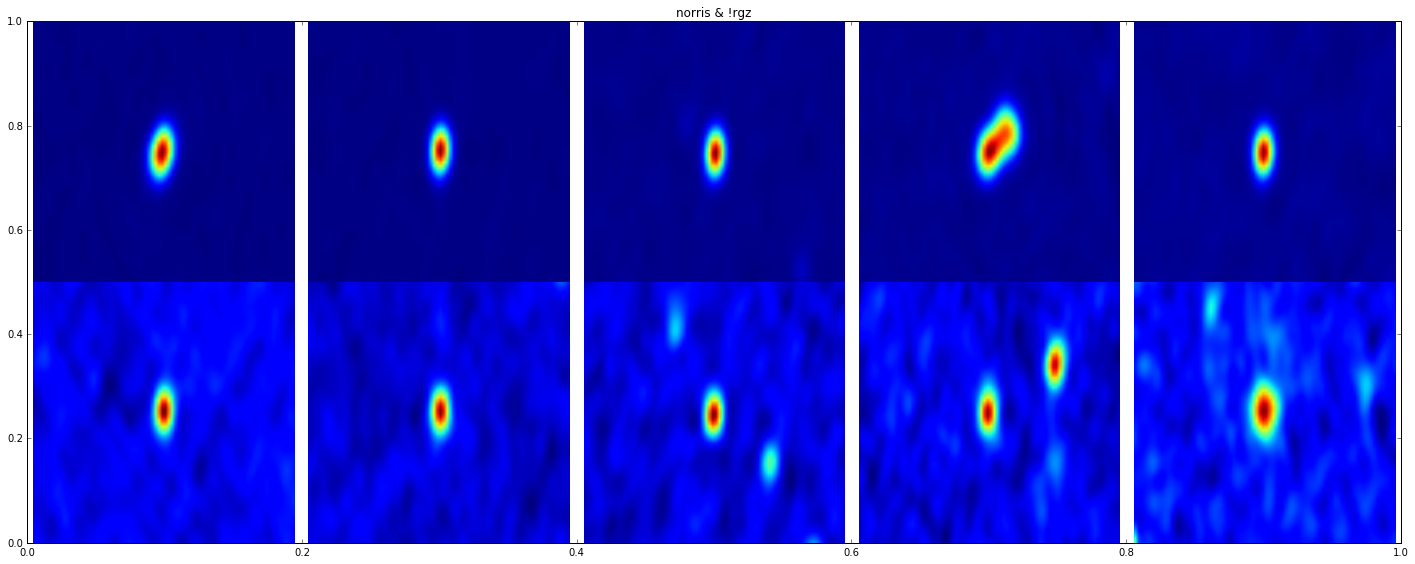

In [60]:
with h5py.File(CROWDASTRO_H5_PATH, 'r') as crowdastro_h5:
    atlas_vectors = crowdastro_h5['/atlas/cdfs/numeric']

    figure = plt.figure(figsize=(20, 8))
    figure.gca().set_title('norris & !rgz')
    for i in range(10):
        axis = figure.add_subplot(2, 5, i + 1)
        atlas_image = atlas_vectors[classifier_norris_not_rgz[i], 2 : 2 + IMAGE_SIZE]
        axis.axis('off')
        plt.imshow(atlas_image.reshape((200, 200))[60 : 140, 60 : 140])
    figure.tight_layout()
    figure.subplots_adjust(wspace=0.01, hspace=0.001)